### MGSC 695 - Optimization for Data Science

#### Winter 2024, Dr.Sanjith Gopalakrishnan

### Assignment 2

#### Submitted by Jared Balakrishnan (McGill ID #261175926)

In [113]:
from pathlib import Path 
import gurobipy as gb
from gurobipy import *
import pandas as pd 
import numpy as np

In [114]:
dataset_path = Path().absolute() / "datasets"

def read_dataset(file_path: Path) -> pd.DataFrame:

    """Function to read in a dataframe from a given filepath."""

    return pd.read_csv(file_path)

In [115]:
advertising_df = read_dataset(dataset_path / "advertising.csv")

In [116]:
advertising_df.head(5)

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


For a linear regression model, the L1 loss function can be written as:

$$
 y_i - (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}) 
 $$

Choosing parameters such that the sum of absolute errors is minimized, ie minimizing the L1 loss function can therefore be written as:

$$
\text{minimize} \sum_{i=1}^{n} \left| y_i - (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}) \right|
$$

The L1 loss function can be expressed as: 

$$
\left| y_i - (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}) \right| = \text{max} \{ y_i - (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}), (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}) - y_i \}
$$

Let's say $y_i - (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}) = w$

We can therefore write:

$$
 w \geq \text{max} \{ y_i - (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}), (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}) - y_i \}
 $$

 $$
 w \geq y_i - (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip})
 $$

  $$
 w \geq (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}) - y_i
 $$

 Therefore we can formulate the linear program as being:
 
 $$
 \text{min}(w) \\
 \text{subject to constraints } w \geq y_i - (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}) \\
 w \geq (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}) - y_i
 $$

 Considering the dataset we are working with seems to be dealing with advertising, it's hard to imagine negative amounts of money being spent on any advertising medium, because of which we can also write a non-negativity constraint as follows:

 $$
 x_{ip} \geq 0 \\
 i = 1, 2, \cdots, n \\
 p = 1, 2, 3
 $$

## Formulating an LP Model in Gurobi

In [117]:
# Initializing an LP Model in Gurobi
linearRegModel = gb.Model("Linear Regression Model (L1 Loss Function)")

In [118]:
# Initializing Decision Variables
Beta = linearRegModel.addVars(4, vtype = GRB.CONTINUOUS, name = [f"Beta_{i}" for i in range(4)])
W = linearRegModel.addVars(len(advertising_df), lb = 0, vtype = GRB.CONTINUOUS)

In [119]:
# Initializing the expression for the objective function
sum_exp = gb.quicksum(W[i] for i in range(len(advertising_df)))
linearRegModel.setObjective(sum_exp, GRB.MINIMIZE)

In [120]:
# Setting up the constraints
for index, row in advertising_df.iterrows():

    linearRegModel.addConstr(W[index] >= row['Sales'] - (Beta[0] + Beta[1]*row['TV'] + Beta[2]*row['Radio'] + Beta[3]*row['Newspaper']), name = "Absolute Value - Positive")
    linearRegModel.addConstr(W[index] >= -row['Sales'] + (Beta[0] + Beta[1]*row['TV'] + Beta[2]*row['Radio'] + Beta[3]*row['Newspaper']), name = "Absolute Value - Negative")

    

In [121]:
linearRegModel.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 400 rows, 204 columns and 1998 nonzeros
Model fingerprint: 0x983d2b74
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 3e+01]
Presolve time: 0.00s
Presolved: 400 rows, 204 columns, 1998 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.497438e+02   0.000000e+00      0s
     245    2.4251181e+02   0.000000e+00   0.000000e+00      0s

Solved in 245 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.425118112e+02


In [122]:
print("Parameter Estimations by using the L1 Loss Function using Gurobi:")

for v in linearRegModel.getVars():
    
    if v.varName[0] == "B":
        print(v.varName, v.x)

Parameter Estimations by using the L1 Loss Function using Gurobi:
Beta_0 3.2797893774713356
Beta_1 0.04382140799173407
Beta_2 0.1967413118206927
Beta_3 0.0


## Comparison of Parameter Estimates to a Linear Regression model with an L2 Loss Function

|    |   L1 Loss Function |   L2 Loss Function |        delta |
|---:|-----------------:|--------------------------:|-------------:|
|  0 |       3.279    |                2.93889    | 0.34011 |
|  1 |       0.0438  |                0.0457646  | -0.0019646 |
|  2 |       0.1967    |                0.18853    | 0.00817 |
|  3 |      0.00 |               -0.00103749 |  -0.00103749 |


Please note Coefficient/Parameter 0 refers to the intercept!

```There is a slight difference, though it's a lot smaller than I would've imagined.```

## Problem 2: Implementing a Linear Classifier in Gurobi

In [123]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt

In [124]:
# Using make_blobs to generate 500 observations
# Two predictors (as indicated by n_features = 2) and one outcome variable
# y stores the integer labels of the observations
X, y = make_blobs(n_samples = 500, n_features = 2, centers = 2, random_state= 42)

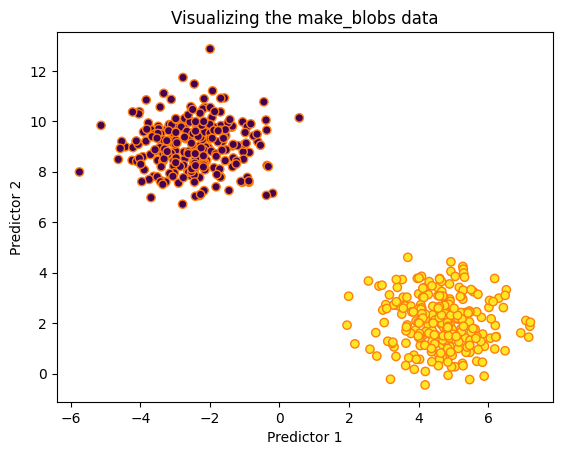

In [125]:
# Creating a scatterplot to visualize the relationship between the observations
plt.scatter(X[:, 0], X[:, 1], c = y, edgecolors = "#ff7f0e")
plt.xlabel('Predictor 1')
plt.ylabel('Predictor 2')
plt.title('Visualizing the make_blobs data')
plt.show()

Looking at the plot, we seem to have a case of perfect separation amongst the observations: ```we should be able to build a linear classifier to separate these points.```

In the case of building a linear classifier, the objective here is to come up with a straight line that separates the purple and yellow dots (considering this is ℝ²). While it is possible to come up with an infinite number of lines to serve as the separation boundary, the question is which one of these is the best.

To summarize the support vector machine problem:
- The line that is farthest from both groups is the best.
- A support vector machine finds the best separating hyperplane $\alpha + \beta^Tx = 0$. 

In this specific case, let's say that:
- a point is purple if $\alpha + \beta^Tx \geq 1$
- a point is yellow if $\alpha + \beta^Tx \leq -1$

The distance between two supporting hyperplanes at two vectors $x_1$ and $x_2$ would be the magnitude of the projection of $x_1 - x_2$ onto the normal of the separating hyperplane $\beta$.

Considering the fact that the line that is farthest from both groups is the best, we need to maximize this distance between the two supporting hyperplanes as mentioned above.

From vectors, it is known that the projection of a vector $a$ onto $w$ is equal to $\frac{a^Tw}{||w||}$ . Therefore, it can be argued that the projection of $x_1 - x_2$ onto the normal of the separating hyperplane $\beta$ is:

$$
\frac{(x_1 - x_2)^T\beta}{||\beta||}
$$

Therefore, the objective of **maximizing the distance between the two supporting hyperplanes** can be written as a maximization problem :

$$
max \frac{(x_1 - x_2)^T\beta}{||\beta||}
$$

subject to constraints (n here refers to the number of points):

$$
y_i(\alpha + \beta^Tx_i) \geq 1 \\
i = 1, \cdots, n
$$


The objective function can be re-written as 

$$

$$

because since $x_1$ and $x_2$ are supporting vectors, we can write:

$$\alpha + \beta^Tx_1 = 1$$
$$\alpha + \beta^Tx_2 = -1$$

The difference between these two equations can therefore be expressed as:

$$
\beta^Tx_1 - \beta^Tx_2 = \beta^T(x_1-x_2) = 2
$$

The objective function when expressed as $ max \frac{2}{||\beta||}$ is not linear in $\beta$, and therefore needs to be re-written as a minimization problem of the inverse:

$$
\frac{1}{2} ||\beta|| = \frac{1}{2} \sum(\beta_i)^2
$$

where $ i = 1, \cdots, n$


Therefore, the problem finally can be expressed as a convex program:

$$
min \frac{1}{2} \sum(\beta_i)^2
$$

$$
y_i(\alpha + \beta^Tx_i) \geq 1 \\
i = 1, \cdots, n
$$

This can now be used to implement a linear classifier using Gurobi.

## Please note that I have not included the case of solving for an imperfect separation problem since my dataset has fortunately been visually perfectly separated which is why I don't discuss it here.





### Implementing a Linear Classifier in Gurobi

In [126]:
linearClassifier = gb.Model("Linear Classifier Implementation in Gurobi")

In [127]:
y_transformed = 2 * y - 1

In [128]:
# Initializing the decision variables

beta = linearClassifier.addVars(2, vtype = GRB.CONTINUOUS, lb = -GRB.INFINITY, ub = GRB.INFINITY, name = [f"weight {i}" for i in range(2)])
bias = linearClassifier.addVar(vtype = GRB.CONTINUOUS, ub = GRB.INFINITY, name = "bias term")

In [129]:
# Setting up the objective function
linearClassifier.setObjective(0.5 * (beta[0]*beta[0] + beta[1]*beta[1]), GRB.MINIMIZE)

In [130]:
# Setting up the constraints

for i in range(len(y_transformed)):

    linearClassifier.addConstr(y_transformed[i] * (beta[0] * X[i, 0] + beta[1] * X[i, 1] + bias) >= 1)

In [131]:
linearClassifier.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 500 rows, 3 columns and 1500 nonzeros
Model fingerprint: 0x11848463
Model has 2 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-02, 1e+01]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 500 rows, 3 columns, 1500 nonzeros
Presolved model has 2 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 2
 AA' NZ     : 1.248e+05
 Factor NZ  : 1.252e+05 (roughly 1 MB of memory)
 Factor Ops : 4.179e+07 (less than 1 second per iteration)
 Threads    : 10

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.38482635e-10 -2.38482635e-10  1.25e+02 1.69e-05  1.00

In [132]:
beta_1 = beta[0].X

In [133]:
beta_2 = beta[1].X

In [109]:
alpha_val = bias.x

In [134]:
linearClassifier.ObjVal

0.10173077576715722

```We have a feasible positive solution while attempting to build our linear classifier!```

In [135]:
print(beta_1, beta_2, alpha_val)

0.2873414262543766 -0.34770167714926986 1.5409302958253908


## Verifying if the linear classifier implementation actually does a good job

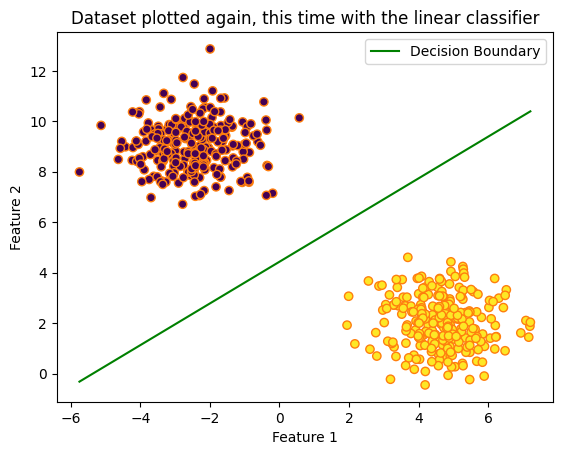

In [136]:
plt.scatter(X[:, 0], X[:, 1], c = y, edgecolors = "#ff7f0e")
x0 = np.linspace(X[:, 0].min(), X[:, 0].max(), 200)
x1 = (-1 * (alpha_val + (beta_1 * x0)))/(beta_2)

plt.plot(x0, x1, color = 'green', label = 'Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title("Dataset plotted again, this time with the linear classifier")
plt.legend()
plt.show()